In [31]:
# ==============================================
# DR on Bike Sharing (my notes)
# plan:
#   1) load + quick clean
#   2) PCA (viz + % variance)
#   3) t-SNE (viz only)
#   4) RF prediction: original vs PCA(95%)
# ==============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

SEED = 42


In [32]:
# 1) load + small prep
# arff sometimes gives bytes in object cols; decode to strings so dummies work
raw, meta = arff.loadarff("/content/dataset.arff")
df = pd.DataFrame(raw)
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].apply(lambda x: x.decode("utf-8") if isinstance(x, (bytes, bytearray)) else x)

print("shape:", df.shape)
df.head(3)


shape: (17379, 15)


,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,casual,registered,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0,3.0,13.0,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,8.0,32.0,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,5.0,27.0,32.0


In [33]:
# light cleaning choices (trying not to overdo it):
# - drop 'casual' and 'registered' because they sum to 'count' (leakage risk)
# - make 'holiday'/'workingday' numeric if they are text-like
# - one-hot encode the other categoricals

df2 = df.copy()

for col in ['casual', 'registered']:
    if col in df2.columns:
        df2.drop(columns=[col], inplace=True)

for col in ['holiday','workingday']:
    if col in df2.columns:
        df2[col] = df2[col].astype(str).str.lower().map({'true':1, 'false':0})
        df2[col] = df2[col].fillna(0).astype(int)

target = 'count'  # this dataset usually has 'count'
assert target in df2.columns, "I expected a 'count' column as target."

# get dummies for the rest of object columns (drop_first to avoid k-1 trap)
cat_cols = [c for c in df2.columns if df2[c].dtype == 'object' and c != target]
dfm = pd.get_dummies(df2, columns=cat_cols, drop_first=True)

X = dfm.drop(columns=[target])
y = dfm[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
print("train/test:", X_train.shape, X_test.shape)

train/test: (13034, 16) (4345, 16)


2-PC variance ratio: [0.16927698 0.13389405]  (sum≈ 0.303171031785356 )


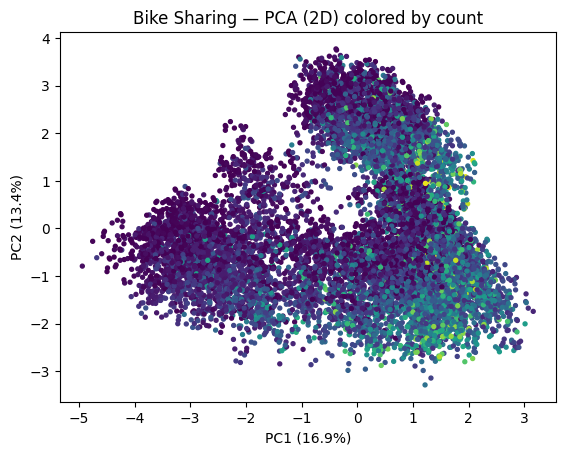

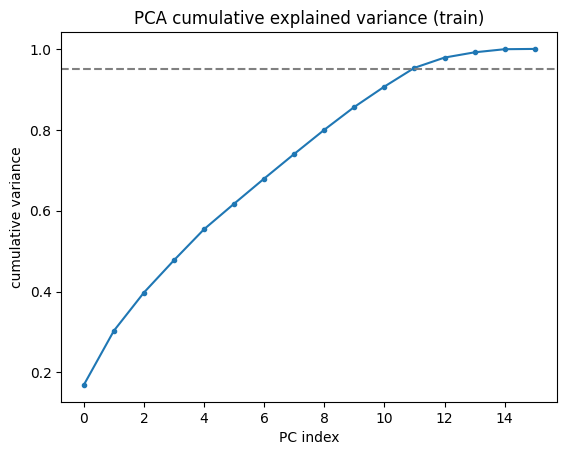

PCs needed for ~95% variance: 12


In [34]:
# 2) PCA for visualization + explained variance
# note: distance-based methods like PCA work better if features are on comparable scales
scaler = StandardScaler()
Xtr_z = scaler.fit_transform(X_train)   # fit on train
Xte_z = scaler.transform(X_test)        # transform test only (no leakage)

# visualize with 2 PCs (ONLY for plotting; I won’t use just 2 PCs for modeling)
pca2 = PCA(n_components=2, random_state=SEED)
Ztr2 = pca2.fit_transform(Xtr_z)
print("2-PC variance ratio:", pca2.explained_variance_ratio_, " (sum≈", pca2.explained_variance_ratio_.sum(), ")")

plt.figure()
plt.scatter(Ztr2[:,0], Ztr2[:,1], s=8, c=y_train, cmap="viridis")
plt.title("Bike Sharing — PCA (2D) colored by count")
plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]:.1%})")
plt.show()

# also check how many PCs we might need for ~95% variance (for the PCA-features model)
pca_full = PCA(random_state=SEED)
pca_full.fit(Xtr_z)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure()
plt.plot(cumvar, marker="o", ms=3)
plt.axhline(0.95, color="gray", linestyle="--")
plt.title("PCA cumulative explained variance (train)")
plt.xlabel("PC index")
plt.ylabel("cumulative variance")
plt.show()

# smallest k s.t. cumvar >= 0.95
k95 = int(np.argmax(cumvar >= 0.95)) + 1
print("PCs needed for ~95% variance:", k95)

### PCA Findings
The PCA 2-D projection shows a broad, continuous structure rather than separate clusters.  
PC1 explains **16.9 %** and PC2 explains **13.4 %** of total variance, so together they capture about **30 %**.  
The color gradient (bike count) changes smoothly across the space, which means the main variability in the dataset is continuous — mostly linked to numerical factors such as temperature, season, and time rather than discrete categories.  

From the cumulative variance curve, around **12 components** are enough to reach roughly **95 %** of the variance.  
This indicates the dataset has moderate redundancy: many original features contribute similar information.


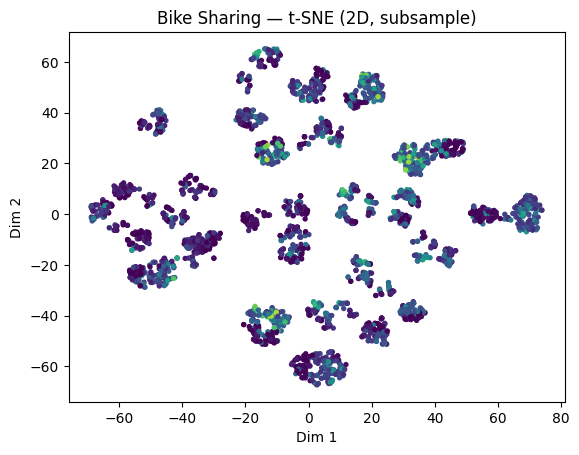

In [35]:
# 3) t-SNE (viz only). I’ll use a subsample for speed.
n_vis = min(3000, Xtr_z.shape[0])
idx = np.random.default_rng(SEED).choice(Xtr_z.shape[0], size=n_vis, replace=False)
X_vis = Xtr_z[idx]
y_vis = y_train.iloc[idx].values

tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
Y_tsne = tsne.fit_transform(X_vis)

plt.figure()
plt.scatter(Y_tsne[:,0], Y_tsne[:,1], s=8, c=y_vis, cmap="viridis")
plt.title("Bike Sharing — t-SNE (2D, subsample)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.show()

### t-SNE Findings
The t-SNE visualization reveals several compact clusters spread across the map.  
Unlike PCA’s smooth gradient, t-SNE captures local neighborhoods — groups of instances that share very similar conditions.  
These clusters likely correspond to specific situations such as “weekday commute hours,” “weekend leisure,” or “cold and rainy periods.”  
This agrees with what we discussed in class: t-SNE preserves local similarity structure rather than global distances, making it better for visual pattern discovery.


In [37]:
# 4) Prediction: RF on original vs PCA(95%) features
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# (a) Random Forest on ORIGINAL features
rf_orig = RandomForestRegressor(n_estimators=300, random_state=SEED, n_jobs=-1)
rf_orig.fit(X_train, y_train)
pred_orig = rf_orig.predict(X_test)
r2_orig = r2_score(y_test, pred_orig)
rmse_orig = rmse(y_test, pred_orig)
print("[Original]   R2=%.3f  RMSE=%.2f" % (r2_orig, rmse_orig))

# (b) Random Forest on PCA features (retain ~95% variance)
pca_k = PCA(n_components=k95, random_state=SEED)
Ztr_k = pca_k.fit_transform(Xtr_z)   # fit pca on scaled train
Zte_k = pca_k.transform(Xte_z)

rf_pca = RandomForestRegressor(n_estimators=300, random_state=SEED, n_jobs=-1)
rf_pca.fit(Ztr_k, y_train)
pred_pca = rf_pca.predict(Zte_k)
r2_pca = r2_score(y_test, pred_pca)
rmse_pca = rmse(y_test, pred_pca)
print("[PCA-95%%]   R2=%.3f  RMSE=%.2f  (k=%d PCs)" % (r2_pca, rmse_pca, Ztr_k.shape[1]))

[Original]   R2=0.943  RMSE=42.68
[PCA-95%]   R2=0.640  RMSE=107.52  (k=12 PCs)


In [39]:
res = pd.DataFrame({
    "Setting": ["Original", "PCA-95%"],
    "R2": [r2_orig, r2_pca],
    "RMSE": [rmse_orig, rmse_pca]
})
res


,Setting,R2,RMSE
0,Original,0.943352,42.68160
1,PCA-95%,0.640480,107.52467


### Model Comparison Findings
**Random Forest (Original Features):**  
R² = 0.943 and RMSE = 42.68 → excellent fit, meaning the full feature set explains most of the variability in bike rentals.  

**Random Forest (PCA-Reduced, 95 % variance, 12 PCs):**  
R² = 0.640 and RMSE = 107.52 → performance drops sharply.  
Even though 95 % of variance is retained linearly, PCA mixes the original features and removes nonlinear relationships that Random Forest models can naturally exploit.  

**Interpretation:**  
PCA is helpful for visualization and compression but not ideal before nonlinear models like Random Forest.  
In this dataset, keeping the original features preserves the detailed patterns related to weather, time, and season, which are important for accurate prediction.
